# 🎓 Fine-Tuning du Cross-Encoder pour EduRanker

Ce notebook permet de **fine-tuner le modèle cross-encoder** sur les feedbacks utilisateurs collectés.

## 📋 Objectifs

1. **Charger les feedbacks** depuis MongoDB (collection `inference`)
2. **Préparer les données** d'entraînement (paires query-document avec labels)
3. **Fine-tuner le modèle** cross-encoder
4. **Évaluer les performances** du modèle
5. **Sauvegarder le modèle** fine-tuné

## 🔧 Prérequis

- MongoDB avec des feedbacks collectés (minimum 50 recommandé)
- Packages Python : `sentence-transformers`, `torch`, `pymongo`
- GPU recommandé (mais CPU possible)

## 1. Installation et Configuration

In [480]:
# Imports
import os
import sys
from pathlib import Path
from datetime import datetime
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

# Ajouter le répertoire racine au path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

print("✅ Imports de base terminés")
print(f"📁 Répertoire projet : {project_root}")

✅ Imports de base terminés
📁 Répertoire projet : /home/dv-fk/Documents/School/Master 2 DS/INF5101 Traitement multimédia des données/Projet  EduRanker/crawler-enduranker-api


In [481]:
# Configuration MongoDB
MONGODB_URL = os.getenv("MONGODB_URL", "mongodb://localhost:27017")
MONGODB_DB = os.getenv("MONGODB_DB_NAME", "eduranker_db")

# Configuration du modèle
BASE_MODEL_NAME = "cross-encoder/ms-marco-MiniLM-L-6-v2"
MODEL_OUTPUT_PATH = str(project_root / "models" / "cross_encoder_finetuned")

# Créer le dossier de sortie
Path(MODEL_OUTPUT_PATH).mkdir(parents=True, exist_ok=True)

print("🔧 Configuration :")
print(f"   MongoDB : {MONGODB_URL}")
print(f"   Database : {MONGODB_DB}")
print(f"   Modèle de base : {BASE_MODEL_NAME}")
print(f"   Sortie : {MODEL_OUTPUT_PATH}")

🔧 Configuration :
   MongoDB : mongodb://localhost:27017
   Database : eduranker_db
   Modèle de base : cross-encoder/ms-marco-MiniLM-L-6-v2
   Sortie : /home/dv-fk/Documents/School/Master 2 DS/INF5101 Traitement multimédia des données/Projet  EduRanker/crawler-enduranker-api/models/cross_encoder_finetuned


## 2. Connexion à MongoDB et Chargement des Données

In [482]:
import pymongo
from bson import ObjectId

# Connexion à MongoDB
client = pymongo.MongoClient(MONGODB_URL)
db = client[MONGODB_DB]

# Collections
inference_col = db["inference"]
resources_col = db["ressources_educatives"]
user_queries_col = db["users_queries"]

print("✅ Connexion MongoDB établie")
print(f"📊 Collections disponibles : {db.list_collection_names()}")

✅ Connexion MongoDB établie
📊 Collections disponibles : ['users_queries', 'inference', 'ressources_educatives']


In [483]:
# Statistiques des inférences
total_inferences = inference_col.count_documents({})
with_feedback = inference_col.count_documents({"feedback": {"$ne": None}})

print(f"\n📈 Statistiques des Inférences :")
print(f"   Total : {total_inferences}")
print(f"   Avec feedback : {with_feedback} ({with_feedback/total_inferences*100:.1f}%)")
print(f"   Sans feedback : {total_inferences - with_feedback}")

# Distribution des feedbacks
feedback_pipeline = [
    {"$match": {"feedback": {"$ne": None}}},
    {"$group": {"_id": "$feedback", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}}
]

feedback_dist = list(inference_col.aggregate(feedback_pipeline))
print(f"\n📊 Distribution des feedbacks :")
for item in feedback_dist:
    print(f"   {item['_id']} : {item['count']}")


📈 Statistiques des Inférences :
   Total : 20
   Avec feedback : 2 (10.0%)
   Sans feedback : 18

📊 Distribution des feedbacks :
   like : 2


## 3. Préparation des Données d'Entraînement

In [484]:
def recuperer_donnees_entrainement(min_feedbacks: int = 1) -> List[Dict]:
    """
    Récupère les données d'entraînement depuis MongoDB
    
    Returns:
        Liste de dictionnaires contenant {query_text, document_text, label}
    """
    print("🔍 Récupération des données d'entraînement...")
    
    # Récupérer les inférences avec feedback like/dislike
    inferences = list(inference_col.find({
        "feedback": {"$in": ["like", "dislike"]}
    }))
    
    if len(inferences) < min_feedbacks:
        print(f"⚠️  Pas assez de feedbacks : {len(inferences)} (minimum : {min_feedbacks})")
        return []
    
    training_data = []
    
    for inference in inferences:
        # Récupérer la requête utilisateur
        user_query = user_queries_col.find_one({"_id": ObjectId(inference["user_query_id"])})
        if not user_query:
            continue
        
        # Récupérer la ressource
        resource = resources_col.find_one({"_id": ObjectId(inference["resource_id"])})
        if not resource:
            continue
        
        # Extraire les textes
        query_text = user_query.get("question", "")
        
        # Créer le texte du document (titre + extrait)
        title = resource.get("titre", "")
        text = resource.get("texte", "")
        if text and len(text) > 1500:
            text = text[:1500] + "..."
        document_text = f"{title}. {text}" if title and text else title or text
        
        # Créer le label (1.0 pour like, 0.0 pour dislike)
        label = 1.0 if inference["feedback"] == "like" else 0.0
        
        training_data.append({
            "query_text": query_text,
            "document_text": document_text,
            "label": label,
            "inference_id": str(inference["_id"]),
            "feedback": inference["feedback"]
        })
    
    print(f"✅ {len(training_data)} exemples d'entraînement récupérés")
    return training_data

# Charger les données
training_data = recuperer_donnees_entrainement()

🔍 Récupération des données d'entraînement...
✅ 2 exemples d'entraînement récupérés


In [485]:
# Créer un DataFrame pour analyse
if training_data:
    df_train = pd.DataFrame(training_data)
    
    print(f"\n📊 Aperçu des données :")
    print(f"   Colonnes : {df_train.columns.tolist()}")
    print(f"   Forme : {df_train.shape}")
    print(f"\n   Distribution des labels :")
    print(df_train['label'].value_counts())
    
    # Afficher quelques exemples
    print(f"\n📝 Premiers exemples :")
    print(df_train[['query_text', 'document_text', 'label']].head(3).to_string())
else:
    print("❌ Aucune donnée d'entraînement disponible")


📊 Aperçu des données :
   Colonnes : ['query_text', 'document_text', 'label', 'inference_id', 'feedback']
   Forme : (2, 5)

   Distribution des labels :
label
1.0    2
Name: count, dtype: int64

📝 Premiers exemples :
                       query_text                                                                                                                                                                                                                                                                                                                                                                                                                                                           document_text  label
0      Comment apprendre Python ?                                                                                                                                                                                                                                                           

## 4. Visualisation des Données

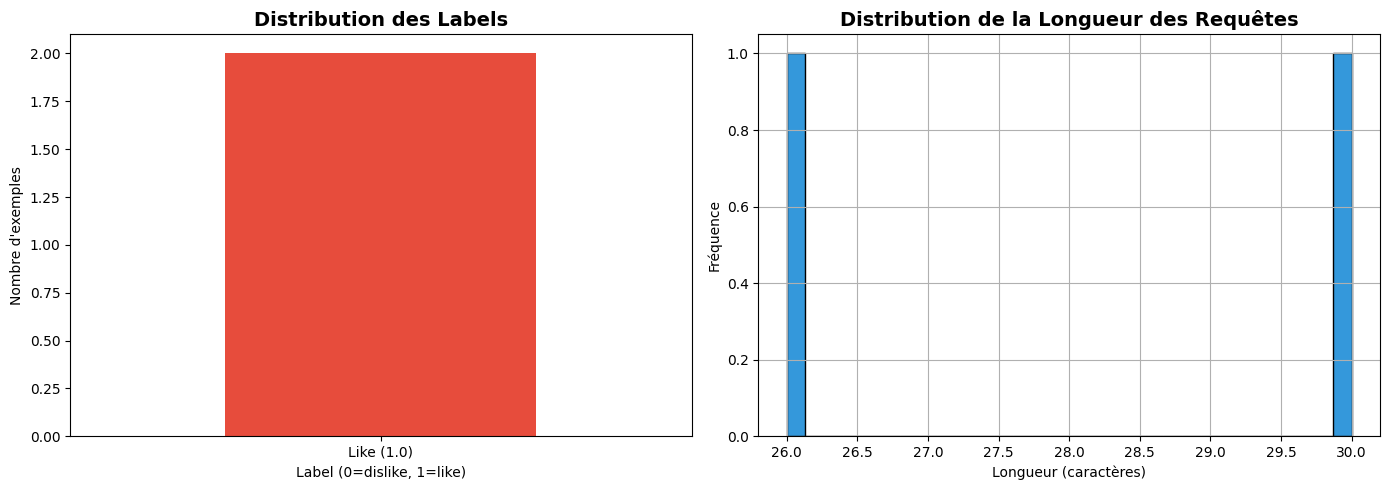


📊 Statistiques de longueur :
   Requête - Moyenne : 28.0 caractères
   Requête - Min : 26
   Requête - Max : 30


In [486]:
if training_data:
    # Distribution des feedbacks
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Distribution des labels
    label_counts = df_train['label'].value_counts().sort_index()
    label_counts.plot(kind='bar', ax=axes[0], color=['#e74c3c', '#2ecc71'])
    axes[0].set_title('Distribution des Labels', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Label (0=dislike, 1=like)')
    axes[0].set_ylabel('Nombre d\'exemples')
    # Définir les labels dynamiquement selon les données disponibles
    tick_labels = ['Dislike (0.0)' if idx == 0.0 else 'Like (1.0)' for idx in label_counts.index]
    axes[0].set_xticklabels(tick_labels, rotation=0)
    
    # Longueur des textes de requête
    df_train['query_length'] = df_train['query_text'].str.len()
    df_train['query_length'].hist(bins=30, ax=axes[1], color='#3498db', edgecolor='black')
    axes[1].set_title('Distribution de la Longueur des Requêtes', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Longueur (caractères)')
    axes[1].set_ylabel('Fréquence')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Statistiques de longueur :")
    print(f"   Requête - Moyenne : {df_train['query_length'].mean():.1f} caractères")
    print(f"   Requête - Min : {df_train['query_length'].min()}")
    print(f"   Requête - Max : {df_train['query_length'].max()}")

## 5. Préparation des Données pour Sentence-Transformers

In [487]:
from sentence_transformers import CrossEncoder, InputExample
from torch.utils.data import DataLoader
import torch

# Vérifier si GPU disponible
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🖥️  Device : {device}")
if device == "cuda":
    print(f"   GPU : {torch.cuda.get_device_name(0)}")
    print(f"   Mémoire : {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

🖥️  Device : cpu


In [488]:
def preparer_data_loaders(
    training_data: List[Dict],
    batch_size: int = 16,
    train_split: float = 0.8
) -> Tuple[DataLoader, DataLoader]:
    """
    Prépare les DataLoaders pour l'entraînement et la validation
    
    Args:
        training_data: Liste des données d'entraînement
        batch_size: Taille des batchs
        train_split: Proportion pour l'entraînement (le reste pour validation)
        
    Returns:
        train_dataloader, val_dataloader
    """
    # Mélanger les données
    np.random.shuffle(training_data)
    
    # Split train/val
    split_idx = int(len(training_data) * train_split)
    train_data = training_data[:split_idx]
    val_data = training_data[split_idx:]
    
    print(f"📊 Split des données :")
    print(f"   Entraînement : {len(train_data)} exemples")
    print(f"   Validation : {len(val_data)} exemples")
    
    # Créer les InputExamples
    train_examples = [
        InputExample(texts=[item['query_text'], item['document_text']], label=float(item['label']))
        for item in train_data
    ]
    
    val_examples = [
        InputExample(texts=[item['query_text'], item['document_text']], label=float(item['label']))
        for item in val_data
    ]
    
    # Créer les DataLoaders
    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
    val_dataloader = DataLoader(val_examples, shuffle=False, batch_size=batch_size)
    
    return train_dataloader, val_dataloader

# Préparer les DataLoaders
if training_data:
    BATCH_SIZE = 16
    train_loader, val_loader = preparer_data_loaders(training_data, batch_size=BATCH_SIZE)
    print(f"✅ DataLoaders créés (batch_size={BATCH_SIZE})")

📊 Split des données :
   Entraînement : 1 exemples
   Validation : 1 exemples
✅ DataLoaders créés (batch_size=16)


## 6. Chargement du Modèle de Base

In [489]:
# Charger le modèle cross-encoder de base
print(f"⏳ Chargement du modèle : {BASE_MODEL_NAME}")

model = CrossEncoder(BASE_MODEL_NAME, num_labels=1, device=device)

print(f"✅ Modèle chargé sur {device}")
print(f"   Nombre de paramètres : {sum(p.numel() for p in model.model.parameters()):,}")

⏳ Chargement du modèle : cross-encoder/ms-marco-MiniLM-L-6-v2
✅ Modèle chargé sur cpu
   Nombre de paramètres : 22,713,601


## 7. Configuration de l'Entraînement

In [490]:
# Hyperparamètres
if training_data:
    NUM_EPOCHS = 3
    LEARNING_RATE = 2e-5
    WARMUP_STEPS = int(len(train_loader) * NUM_EPOCHS * 0.1)

    print("🎛️  Hyperparamètres :")
    print(f"   Epochs : {NUM_EPOCHS}")
    print(f"   Batch size : {BATCH_SIZE}")
    print(f"   Learning rate : {LEARNING_RATE}")
    print(f"   Warmup steps : {WARMUP_STEPS}")
    print(f"   Total steps : {len(train_loader) * NUM_EPOCHS}")
else:
    print("⚠️  Aucune donnée d'entraînement disponible. Ignoré.")

🎛️  Hyperparamètres :
   Epochs : 3
   Batch size : 16
   Learning rate : 2e-05
   Warmup steps : 0
   Total steps : 3


## 8. Fonction d'Évaluation

In [491]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluer_modele(model: CrossEncoder, val_loader: DataLoader) -> Dict:
    """
    Évalue le modèle sur le jeu de validation
    
    Returns:
        Dictionnaire avec les métriques
    """
    print("📊 Évaluation du modèle...")
    
    y_true = []
    y_pred = []
    y_scores = []
    
    # Itérer directement sur le dataset au lieu du DataLoader
    val_dataset = val_loader.dataset
    
    for example in val_dataset:
        # Prédiction pour un seul exemple
        text_pair = [example.texts[0], example.texts[1]]
        label = example.label
        
        # Prédiction
        score = model.predict([text_pair], show_progress_bar=False)[0]
        
        y_true.append(label)
        y_scores.append(score)
        
        # Seuil à 0.5 pour classification binaire
        prediction = 1.0 if score > 0.5 else 0.0
        y_pred.append(prediction)
    
    # Calculer les métriques
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "auc": roc_auc_score(y_true, y_scores) if len(set(y_true)) > 1 else 0.5
    }
    
    return metrics, y_true, y_pred, y_scores

# Évaluation avant fine-tuning (baseline)
if training_data:
    print("\n🎯 Évaluation AVANT fine-tuning (baseline) :")
    metrics_before, _, _, _ = evaluer_modele(model, val_loader)
    
    for metric, value in metrics_before.items():
        print(f"   {metric.capitalize():12} : {value:.4f}")


🎯 Évaluation AVANT fine-tuning (baseline) :
📊 Évaluation du modèle...
   Accuracy     : 0.0000
   Precision    : 0.0000
   Recall       : 0.0000
   F1           : 0.0000
   Auc          : 0.5000


## 9. Fine-Tuning du Modèle 🚀

In [492]:
# Fine-tuning
if training_data:
    print("\n" + "="*70)
    print("🎓 DÉBUT DU FINE-TUNING")
    print("="*70)
    
    start_time = datetime.now()
    
    # Entraîner le modèle
    model.fit(
        train_dataloader=train_loader,
        epochs=NUM_EPOCHS,
        warmup_steps=WARMUP_STEPS,
        output_path=MODEL_OUTPUT_PATH,
        show_progress_bar=True,
        optimizer_params={'lr': LEARNING_RATE}
    )
    
    end_time = datetime.now()
    duration = (end_time - start_time).total_seconds()
    
    print("\n" + "="*70)
    print(f"✅ FINE-TUNING TERMINÉ en {duration:.1f} secondes ({duration/60:.1f} minutes)")
    print("="*70)


🎓 DÉBUT DU FINE-TUNING


Epoch: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


✅ FINE-TUNING TERMINÉ en 1.6 secondes (0.0 minutes)


## 10. Évaluation du Modèle Fine-Tuné

In [493]:
# Recharger le modèle fine-tuné
if training_data:
    print("⏳ Rechargement du modèle fine-tuné...")
    
    # Vérifier si le modèle a été sauvegardé
    model_files = list(Path(MODEL_OUTPUT_PATH).glob("*"))
    print(f"📁 Fichiers dans {MODEL_OUTPUT_PATH}:")
    for file in model_files:
        print(f"   - {file.name}")
    
    # Vérifier si config.json existe
    config_file = Path(MODEL_OUTPUT_PATH) / "config.json"
    
    if config_file.exists():
        # Charger le modèle fine-tuné
        model_finetuned = CrossEncoder(MODEL_OUTPUT_PATH, num_labels=1, device=device)
        print("✅ Modèle fine-tuné rechargé")
    else:
        print("⚠️  config.json manquant, utilisation du modèle en mémoire")
        # Utiliser le modèle qui vient d'être entraîné (toujours en mémoire)
        model_finetuned = model
        
        # Sauvegarder manuellement le modèle
        print("💾 Sauvegarde manuelle du modèle...")
        model.save(MODEL_OUTPUT_PATH)
        print(f"✅ Modèle sauvegardé dans {MODEL_OUTPUT_PATH}")

    # Évaluation après fine-tuning
    print("\n🎯 Évaluation APRÈS fine-tuning :")
    metrics_after, y_true, y_pred, y_scores = evaluer_modele(model_finetuned, val_loader)
    
    for metric, value in metrics_after.items():
        print(f"   {metric.capitalize():12} : {value:.4f}")
else:
    print("⚠️  Aucune donnée d'entraînement disponible. Ignoré.")

⏳ Rechargement du modèle fine-tuné...
📁 Fichiers dans /home/dv-fk/Documents/School/Master 2 DS/INF5101 Traitement multimédia des données/Projet  EduRanker/crawler-enduranker-api/models/cross_encoder_finetuned:
⚠️  config.json manquant, utilisation du modèle en mémoire
💾 Sauvegarde manuelle du modèle...
✅ Modèle sauvegardé dans /home/dv-fk/Documents/School/Master 2 DS/INF5101 Traitement multimédia des données/Projet  EduRanker/crawler-enduranker-api/models/cross_encoder_finetuned

🎯 Évaluation APRÈS fine-tuning :
📊 Évaluation du modèle...
   Accuracy     : 0.0000
   Precision    : 0.0000
   Recall       : 0.0000
   F1           : 0.0000
   Auc          : 0.5000


In [494]:
# Comparaison des performances
if training_data:
    print("\n📈 AMÉLIORATION DES PERFORMANCES :")
    print("="*70)
    
    comparison_df = pd.DataFrame({
        'Métrique': list(metrics_before.keys()),
        'Avant': list(metrics_before.values()),
        'Après': list(metrics_after.values())
    })
    
    comparison_df['Amélioration'] = comparison_df['Après'] - comparison_df['Avant']
    comparison_df['Amélioration %'] = (comparison_df['Amélioration'] / comparison_df['Avant'] * 100)
    
    print(comparison_df.to_string(index=False))



📈 AMÉLIORATION DES PERFORMANCES :
 Métrique  Avant  Après  Amélioration  Amélioration %
 accuracy    0.0    0.0           0.0             NaN
precision    0.0    0.0           0.0             NaN
   recall    0.0    0.0           0.0             NaN
       f1    0.0    0.0           0.0             NaN
      auc    0.5    0.5           0.0             0.0


## 11. Visualisation des Résultats

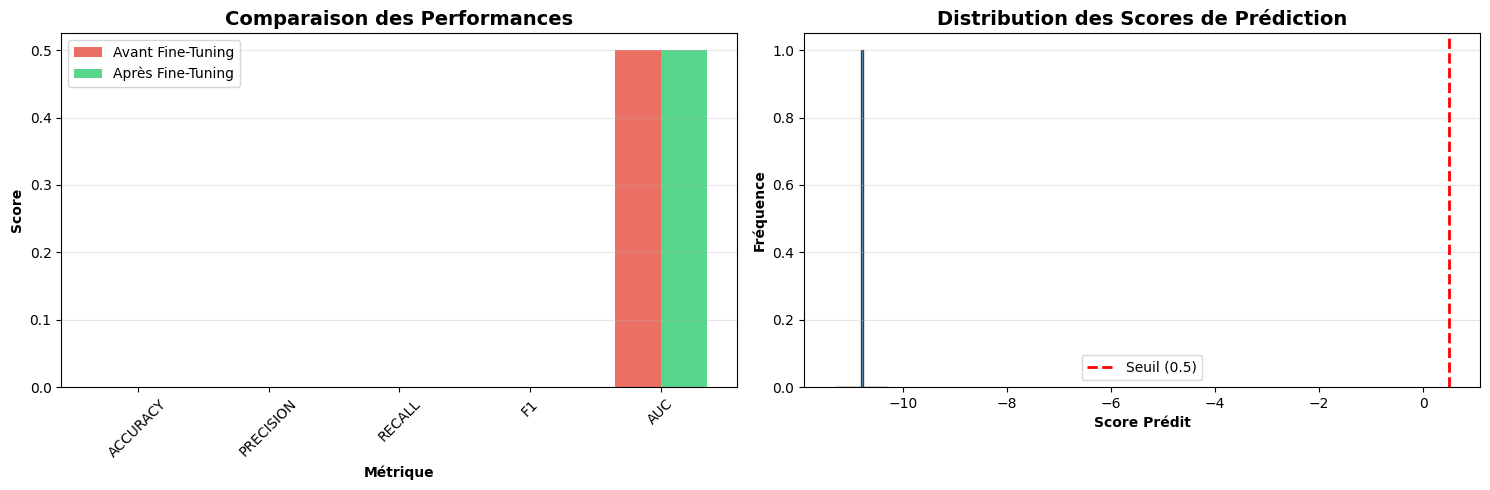

In [495]:
if training_data:
    # Comparaison des métriques
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Graphique à barres pour comparer avant/après
    metrics_names = list(metrics_before.keys())
    x = np.arange(len(metrics_names))
    width = 0.35
    
    axes[0].bar(x - width/2, [metrics_before[m] for m in metrics_names], width, 
                label='Avant Fine-Tuning', color='#e74c3c', alpha=0.8)
    axes[0].bar(x + width/2, [metrics_after[m] for m in metrics_names], width, 
                label='Après Fine-Tuning', color='#2ecc71', alpha=0.8)
    
    axes[0].set_xlabel('Métrique', fontweight='bold')
    axes[0].set_ylabel('Score', fontweight='bold')
    axes[0].set_title('Comparaison des Performances', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels([m.upper() for m in metrics_names], rotation=45)
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # Distribution des scores prédits
    axes[1].hist(y_scores, bins=30, color='#3498db', edgecolor='black', alpha=0.7)
    axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Seuil (0.5)')
    axes[1].set_xlabel('Score Prédit', fontweight='bold')
    axes[1].set_ylabel('Fréquence', fontweight='bold')
    axes[1].set_title('Distribution des Scores de Prédiction', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


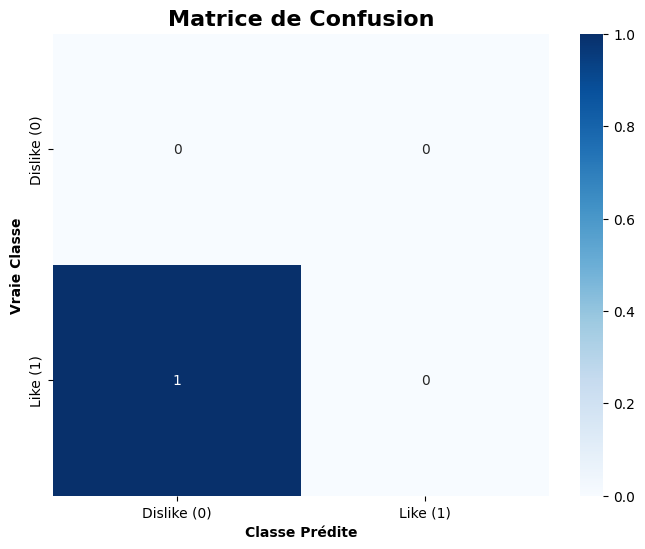


📊 Matrice de confusion :
   Shape : (2, 2)
   Classes présentes : [0.0, 1.0]
   True Negatives  : 0
   False Positives : 0
   False Negatives : 1
   True Positives  : 0


In [496]:
if training_data:
    # Matrice de confusion
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    cm = confusion_matrix(y_true, y_pred)
    
    # Déterminer les labels présents
    unique_labels = sorted(list(set(y_true) | set(y_pred)))
    n_classes = len(unique_labels)
    
    # Créer les labels pour l'affichage
    if n_classes == 2:
        class_labels = ['Dislike (0)', 'Like (1)']
    else:
        class_labels = [f'Classe {int(label)}' for label in unique_labels]
    
    # Afficher la matrice de confusion
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels[:n_classes],
                yticklabels=class_labels[:n_classes])
    plt.title('Matrice de Confusion', fontsize=16, fontweight='bold')
    plt.ylabel('Vraie Classe', fontweight='bold')
    plt.xlabel('Classe Prédite', fontweight='bold')
    plt.show()
    
    # Afficher les statistiques de manière robuste
    print(f"\n📊 Matrice de confusion :")
    print(f"   Shape : {cm.shape}")
    print(f"   Classes présentes : {unique_labels}")
    
    if cm.shape == (2, 2):
        # Matrice 2x2 complète
        print(f"   True Negatives  : {cm[0,0]}")
        print(f"   False Positives : {cm[0,1]}")
        print(f"   False Negatives : {cm[1,0]}")
        print(f"   True Positives  : {cm[1,1]}")
    elif cm.shape == (1, 1):
        # Une seule classe
        print(f"   ⚠️  Une seule classe détectée")
        print(f"   Total correct   : {cm[0,0]}")
        print(f"\n   💡 Conseil : Vos données ne contiennent qu'une seule classe.")
        print(f"      Essayez d'ajouter plus de feedbacks variés (like ET dislike).")
    else:
        # Cas général
        print("\n   Détails de la matrice :")
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                print(f"   [{i},{j}] : {cm[i,j]}")

## 12. Test du Modèle sur Nouveaux Exemples

In [497]:
def tester_predictions(model: CrossEncoder, examples: List[Tuple[str, str]]):
    """
    Teste le modèle sur de nouveaux exemples
    
    Args:
        model: Modèle cross-encoder
        examples: Liste de tuples (query, document)
    """
    print("\n🧪 Test sur nouveaux exemples :")
    print("="*70)
    
    for i, (query, doc) in enumerate(examples, 1):
        # Corriger : model.predict attend une liste de paires [[query, doc]]
        score = model.predict([[query, doc]])[0]
        score_norm = 1 / (1 + np.exp(-score))  # Sigmoïde pour normaliser
        
        prediction = "👍 PERTINENT" if score > 0.5 else "👎 NON PERTINENT"
        
        print(f"\n📝 Exemple {i} :")
        print(f"   Query    : {query}")
        print(f"   Document : {doc[:100]}...")
        print(f"   Score    : {score:.4f} (normalisé : {score_norm:.4f})")
        print(f"   Verdict  : {prediction}")

if training_data:
    # Exemples de test
    test_examples = [
        ("machine learning tutoriel", "Guide complet pour apprendre le machine learning avec Python"),
        ("recette de crêpes", "Tutoriel avancé sur les réseaux de neurones convolutifs"),
        ("histoire de France", "Les grandes dates de l'histoire de France : Révolution, Empire, République"),
        ("python programming", "Introduction to Python programming for beginners with examples"),
    ]

    tester_predictions(model_finetuned, test_examples)
else:
    print("⚠️  Aucune donnée d'entraînement disponible. Ignoré.")


🧪 Test sur nouveaux exemples :

📝 Exemple 1 :
   Query    : machine learning tutoriel
   Document : Guide complet pour apprendre le machine learning avec Python...
   Score    : 0.9170 (normalisé : 0.7144)
   Verdict  : 👍 PERTINENT

📝 Exemple 2 :
   Query    : recette de crêpes
   Document : Tutoriel avancé sur les réseaux de neurones convolutifs...
   Score    : -11.0622 (normalisé : 0.0000)
   Verdict  : 👎 NON PERTINENT

📝 Exemple 3 :
   Query    : histoire de France
   Document : Les grandes dates de l'histoire de France : Révolution, Empire, République...
   Score    : 6.1871 (normalisé : 0.9979)
   Verdict  : 👍 PERTINENT

📝 Exemple 4 :
   Query    : python programming
   Document : Introduction to Python programming for beginners with examples...
   Score    : 7.1476 (normalisé : 0.9992)
   Verdict  : 👍 PERTINENT


## 13. Sauvegarde des Métadonnées

In [498]:
# Sauvegarder les métadonnées du fine-tuning
if training_data:
    metadata = {
        "model_version": f"finetuned_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
        "base_model": BASE_MODEL_NAME,
        "num_training_samples": len(training_data),
        "train_samples": len(train_loader.dataset),
        "val_samples": len(val_loader.dataset),
        "num_epochs": NUM_EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "warmup_steps": WARMUP_STEPS,
        "training_date": datetime.now().isoformat(),
        "training_duration_seconds": duration,
        "device": device,
        "metrics_before": metrics_before,
        "metrics_after": metrics_after,
        "improvement": {k: metrics_after[k] - metrics_before[k] for k in metrics_before.keys()}
    }
    
    # Sauvegarder
    metadata_path = Path(MODEL_OUTPUT_PATH) / "training_metadata.pkl"
    with open(metadata_path, 'wb') as f:
        pickle.dump(metadata, f)
    
    print(f"\n💾 Métadonnées sauvegardées dans : {metadata_path}")
    
    # Afficher un résumé
    print("\n" + "="*70)
    print("📊 RÉSUMÉ DU FINE-TUNING")
    print("="*70)
    print(f"✅ Modèle de base     : {BASE_MODEL_NAME}")
    print(f"✅ Échantillons      : {len(training_data)} total ({metadata['train_samples']} train, {metadata['val_samples']} val)")
    print(f"✅ Epochs            : {NUM_EPOCHS}")
    print(f"✅ Durée             : {duration:.1f}s ({duration/60:.1f} min)")
    print(f"✅ Device            : {device}")
    print(f"✅ Modèle sauvegardé : {MODEL_OUTPUT_PATH}")
    print("\n📈 Amélioration des performances :")
    for metric, improvement in metadata['improvement'].items():
        before = metrics_before[metric]
        after = metrics_after[metric]
        
        # Gérer la division par zéro
        if before == 0:
            if after == 0:
                pct_change = 0.0
                print(f"   {metric.capitalize():12} : {improvement:+.4f} (N/A - valeurs nulles)")
            else:
                print(f"   {metric.capitalize():12} : {improvement:+.4f} (∞ - amélioration depuis 0)")
        else:
            pct_change = (improvement / before) * 100
            print(f"   {metric.capitalize():12} : {improvement:+.4f} ({pct_change:+.1f}%)")
    print("="*70)


💾 Métadonnées sauvegardées dans : /home/dv-fk/Documents/School/Master 2 DS/INF5101 Traitement multimédia des données/Projet  EduRanker/crawler-enduranker-api/models/cross_encoder_finetuned/training_metadata.pkl

📊 RÉSUMÉ DU FINE-TUNING
✅ Modèle de base     : cross-encoder/ms-marco-MiniLM-L-6-v2
✅ Échantillons      : 2 total (1 train, 1 val)
✅ Epochs            : 3
✅ Durée             : 1.6s (0.0 min)
✅ Device            : cpu
✅ Modèle sauvegardé : /home/dv-fk/Documents/School/Master 2 DS/INF5101 Traitement multimédia des données/Projet  EduRanker/crawler-enduranker-api/models/cross_encoder_finetuned

📈 Amélioration des performances :
   Accuracy     : +0.0000 (N/A - valeurs nulles)
   Precision    : +0.0000 (N/A - valeurs nulles)
   Recall       : +0.0000 (N/A - valeurs nulles)
   F1           : +0.0000 (N/A - valeurs nulles)
   Auc          : +0.0000 (+0.0%)


## 14. Export du Rapport d'Entraînement

In [499]:
# Créer un rapport au format texte
if training_data:
    report_path = Path(MODEL_OUTPUT_PATH) / "training_report.txt"
    
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("="*70 + "\n")
        f.write("📊 RAPPORT DE FINE-TUNING - CROSS-ENCODER EDURANKER\n")
        f.write("="*70 + "\n\n")
        
        f.write(f"📅 Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        f.write("🔧 CONFIGURATION\n")
        f.write("-"*70 + "\n")
        f.write(f"Modèle de base       : {BASE_MODEL_NAME}\n")
        f.write(f"Sortie               : {MODEL_OUTPUT_PATH}\n")
        f.write(f"Device               : {device}\n")
        f.write(f"MongoDB URL          : {MONGODB_URL}\n")
        f.write(f"Database             : {MONGODB_DB}\n\n")
        
        f.write("📊 DONNÉES\n")
        f.write("-"*70 + "\n")
        f.write(f"Total échantillons   : {len(training_data)}\n")
        f.write(f"Entraînement         : {metadata['train_samples']}\n")
        f.write(f"Validation           : {metadata['val_samples']}\n")
        f.write(f"Distribution labels  :\n")
        f.write(f"  - Like (1.0)       : {sum(1 for x in training_data if x['label'] == 1.0)}\n")
        f.write(f"  - Dislike (0.0)    : {sum(1 for x in training_data if x['label'] == 0.0)}\n\n")
        
        f.write("🎛️  HYPERPARAMÈTRES\n")
        f.write("-"*70 + "\n")
        f.write(f"Epochs               : {NUM_EPOCHS}\n")
        f.write(f"Batch size           : {BATCH_SIZE}\n")
        f.write(f"Learning rate        : {LEARNING_RATE}\n")
        f.write(f"Warmup steps         : {WARMUP_STEPS}\n")
        f.write(f"Durée totale         : {duration:.1f}s ({duration/60:.1f} min)\n\n")
        
        f.write("📈 PERFORMANCES\n")
        f.write("-"*70 + "\n")
        f.write("Métrique      | Avant    | Après    | Amélioration\n")
        f.write("-"*70 + "\n")
        for metric in metrics_before.keys():
            before = metrics_before[metric]
            after = metrics_after[metric]
            improvement = after - before
            
            # Gérer la division par zéro
            if before == 0:
                if after == 0:
                    pct_str = "N/A"
                else:
                    pct_str = "∞"
            else:
                pct = (improvement / before) * 100
                pct_str = f"{pct:+.1f}%"
            
            f.write(f"{metric.capitalize():12} | {before:.4f}   | {after:.4f}   | {improvement:+.4f} ({pct_str})\n")
        
        f.write("\n" + "="*70 + "\n")
        f.write("✅ Fine-tuning terminé avec succès !\n")
        f.write("="*70 + "\n")
    
    print(f"\n📄 Rapport sauvegardé : {report_path}")


📄 Rapport sauvegardé : /home/dv-fk/Documents/School/Master 2 DS/INF5101 Traitement multimédia des données/Projet  EduRanker/crawler-enduranker-api/models/cross_encoder_finetuned/training_report.txt


## 15. Utilisation du Modèle Fine-Tuné

Pour utiliser le modèle fine-tuné dans l'API :

```python
from sentence_transformers import CrossEncoder

# Charger le modèle
model = CrossEncoder('models/cross_encoder_finetuned')

# Prédire
score = model.predict([query, document])[0]
```

Dans `reranking_service.py`, le modèle sera automatiquement chargé depuis `models/cross_encoder_finetuned` si le dossier existe.

## 16. Prochaines Étapes

✅ **Modèle fine-tuné et sauvegardé !**

**Pour aller plus loin :**

1. **Collecter plus de feedbacks** : Plus de données = meilleur modèle
2. **Réentraîner périodiquement** : Relancer ce notebook avec les nouvelles données
3. **Expérimenter** : Tester différents hyperparamètres (epochs, learning_rate, etc.)
4. **A/B Testing** : Comparer modèle de base vs fine-tuné en production
5. **Monitoring** : Suivre les performances du modèle en production

**Commandes utiles :**

```bash
# Démarrer l'API avec le modèle fine-tuné
python main.py

# Tester via l'API
curl -X POST "http://localhost:8000/api/reranking/search-with-reranking" \
  -H "Content-Type: application/json" \
  -d '{"query_text": "machine learning tutorial", "use_reranker": true}'
```

## 🎉 Conclusion

Le fine-tuning du cross-encoder est terminé ! Le modèle a été entraîné sur les feedbacks utilisateurs et est maintenant optimisé pour votre cas d'usage spécifique.

**Fichiers générés :**
- `models/cross_encoder_finetuned/` : Modèle fine-tuné
- `models/cross_encoder_finetuned/training_metadata.pkl` : Métadonnées
- `models/cross_encoder_finetuned/training_report.txt` : Rapport détaillé

**L'API utilisera automatiquement ce modèle** lors du prochain démarrage.
